# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [ ]:
!pip -q install ./python

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
seed=4

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='Reacher', seed=seed)

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e+00
 -8.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -6.97666168e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [4]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


In [8]:
from ddpg_agent import Agent
from collections import deque
import torch

agent = Agent(state_size, action_size, seed)
agent.actor_local.load_state_dict(torch.load('actor.pth'))
agent.critic_local.load_state_dict(torch.load('critic.pth'))

#test
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations            # get the current state
action = agent.act(1, state)
print(action)
env_info = env.step(action)[brain_name]        # send the action to the environment
next_state = env_info.vector_observations[0]
reward = env_info.rewards[0]
print(reward)


[[-0.95276386 -0.97933716 -0.8165871   1.        ]]
0.0


# Training

When finished, you can close the environment.

In [9]:
repeat_every = 5
def train(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.1, eps_decay=0.00001):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []      # list containing scores from each episode
    scores_window = deque(maxlen=repeat_every)  # last 5 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations          # get the current state
        agent.reset()
        score = np.zeros(num_agents)
        for t in range(max_t):
            action = agent.act(eps, state)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = (env_info.local_done)
            score += reward
            agent.step(t, state, action, reward, next_state, done)
            state = next_state

            if np.any(done):
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps-eps_decay) # decrease epsilon
        if i_episode % repeat_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'actor.pth')
            torch.save(agent.critic_local.state_dict(), 'critic.pth')
        if np.mean(scores_window) >= 30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean( scores_window )))
            torch.save(agent.actor_local.state_dict(), 'actor.pth')
            torch.save(agent.critic_local.state_dict(), 'critic.pth')
            break

    return scores

scores = train ()

Episode 5	Average Score: 3.07
Episode 10	Average Score: 2.56
Episode 15	Average Score: 1.39
Episode 20	Average Score: 1.74
Episode 25	Average Score: 1.16
Episode 30	Average Score: 2.06
Episode 35	Average Score: 1.40
Episode 40	Average Score: 2.54
Episode 45	Average Score: 1.87
Episode 50	Average Score: 2.06
Episode 55	Average Score: 4.20
Episode 60	Average Score: 3.33
Episode 65	Average Score: 2.40
Episode 70	Average Score: 3.48
Episode 75	Average Score: 1.77
Episode 80	Average Score: 1.30
Episode 85	Average Score: 2.49
Episode 90	Average Score: 2.41
Episode 95	Average Score: 2.43
Episode 100	Average Score: 2.09
Episode 105	Average Score: 2.75
Episode 110	Average Score: 2.93
Episode 115	Average Score: 2.27
Episode 120	Average Score: 2.22
Episode 125	Average Score: 3.63
Episode 130	Average Score: 3.08
Episode 135	Average Score: 3.14
Episode 140	Average Score: 2.94
Episode 145	Average Score: 3.95
Episode 150	Average Score: 2.96
Episode 155	Average Score: 3.29
Episode 160	Average Score: 5

Episode 1280	Average Score: 6.64
Episode 1285	Average Score: 8.10
Episode 1290	Average Score: 9.14
Episode 1295	Average Score: 7.72
Episode 1300	Average Score: 7.37
Episode 1305	Average Score: 7.85
Episode 1310	Average Score: 9.51
Episode 1315	Average Score: 8.12
Episode 1320	Average Score: 8.77
Episode 1325	Average Score: 9.10
Episode 1330	Average Score: 6.79
Episode 1335	Average Score: 8.37
Episode 1340	Average Score: 7.62
Episode 1345	Average Score: 8.38
Episode 1350	Average Score: 7.27
Episode 1355	Average Score: 6.09
Episode 1360	Average Score: 7.94
Episode 1365	Average Score: 8.49
Episode 1370	Average Score: 8.82
Episode 1375	Average Score: 7.78
Episode 1380	Average Score: 9.86
Episode 1385	Average Score: 8.98
Episode 1390	Average Score: 7.43
Episode 1395	Average Score: 11.02
Episode 1400	Average Score: 6.84
Episode 1405	Average Score: 9.83
Episode 1410	Average Score: 8.65
Episode 1415	Average Score: 6.44
Episode 1420	Average Score: 7.27
Episode 1425	Average Score: 5.73
Episode 1

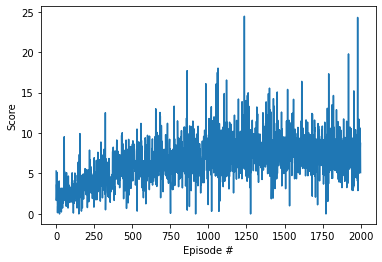

In [10]:
import matplotlib.pyplot as plt
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')

plt.xlabel('Episode #')
plt.show()


In [11]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 